<a href="https://www.kaggle.com/code/guidosalimbeni/gan-3d-morandi-images?scriptVersionId=125234224" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

* **GAN** (Generative Adversarial Network) is a deep learning architecture that can generate synthetic data that resembles real data. The idea behind GANs is to have two neural networks that compete with each other: a generator and a discriminator. The generator tries to create synthetic data that can fool the discriminator, while the discriminator tries to distinguish between the synthetic data and the real data. Through this adversarial training process, the generator becomes better at generating realistic data, while the discriminator becomes better at distinguishing between the real and fake data.

* **In this notebook**, we will be using GANs to generate images of compositions inspired by the work of Giorgio Morandi. Giorgio Morandi was an Italian painter known for his still-life compositions, particularly his use of simple shapes and muted colors. We will use a dataset of Morandi-inspired compositions and train a GAN to generate new, synthetic compositions that resemble those in the dataset. The goal is to create a generator that can produce novel and compelling compositions that capture the essence of Morandi's style.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from PIL import ImageOps
import cv2
from skimage.metrics import structural_similarity as ssim

# Custom loss function with brightness constraint
def custom_loss(y_true, y_pred):
    mse = tf.keras.losses.MeanSquaredError()
    brightness_loss = tf.reduce_mean(tf.abs(tf.reduce_mean(y_pred) - tf.reduce_mean(y_true)))
    return mse(y_true, y_pred) # + brightness_loss

def custom_loss_with_brightness(y_true, y_pred, real_imgs, gen_imgs):
    mse = tf.keras.losses.MeanSquaredError()
    base_loss = mse(y_true, y_pred)

    # Calculate the average brightness of the generated images
    brightness_gen = tf.reduce_mean(gen_imgs)

    # Brightness constraint
    min_brightness = 0.5
    brightness_loss = tf.maximum(0.0, min_brightness - brightness_gen)

    # Combine base loss and brightness constraint
    total_loss = base_loss + brightness_loss

    return total_loss

def calculate_golden_rule_score(image_tensor):
    
    image = image_tensor.numpy()

    # Ensure the image has the correct depth (8-bit unsigned integer)
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)

    # Detect keypoints using SIFT
    sift = cv2.SIFT_create()
    keypoints = sift.detect(image, None)

    # Find the most important point
    most_important_point = max(keypoints, key=lambda x: x.response).pt

    # Find the center of the image
    center_x, center_y = image.shape[1] / 2, image.shape[0] / 2

    # Normalize the coordinates of the most important point relative to the center
    norm_x, norm_y = most_important_point[0] - center_x, most_important_point[1] - center_y

    # Convert the normalized Cartesian coordinates to polar coordinates
    r, theta = np.sqrt(norm_x**2 + norm_y**2), np.arctan2(norm_y, norm_x)

    # Calculate the angle difference between the most important point and the closest point on the golden spiral
    golden_ratio = (1 + np.sqrt(5)) / 2
    b = 2 * np.pi / np.log(golden_ratio)
    theta_golden = theta % b
    angle_diff = min(abs(theta - theta_golden), abs(theta - (theta_golden + b)))

    # Normalize the angle difference to a range of [0, 1]
    max_angle_diff = np.pi
    normalized_angle_diff = angle_diff / max_angle_diff

    # Calculate the score
    score = 1 - normalized_angle_diff

    return score

image_path1 = "/kaggle/input/single-image/base.png"
image_np1 = cv2.imread(image_path1)

def image_similarity_score(image_np1, image_np2):
    # Ensure both images have the same shape
    image = image_np2.numpy()

#     # Ensure the image has the correct depth (8-bit unsigned integer)
#     if image.dtype != np.uint8:
#         image = (image * 255).astype(np.uint8)
    
    if image_np1.shape != image.shape:
        raise ValueError("Images must have the same shape")

    # Convert images to grayscale if they are not
    if len(image_np1.shape) == 3:
        image_np1 = cv2.cvtColor(image_np1, cv2.COLOR_BGR2GRAY)

    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Compute SSIM between the two images
    similarity = ssim(image_np1, image)

    # SSIM returns a value in the range of [-1, 1]. Normalize it to [0, 1].
    normalized_similarity = (similarity + 1) / 2

    return normalized_similarity

def custom_loss_with_black_pixels(y_true, y_pred, real_imgs, gen_imgs, black_pixel_threshold=0.1, constraint_weight=0.02):
    mse = tf.keras.losses.MeanSquaredError()
    base_loss = mse(y_true, y_pred)

    # Calculate the number of black pixels on both sides of the generated images
    left_side = gen_imgs[:, :, :gen_imgs.shape[2] // 2]
    right_side = gen_imgs[:, :, gen_imgs.shape[2] // 2:]
    black_pixels_left = tf.reduce_sum(tf.cast(left_side <= black_pixel_threshold, tf.float32))
    black_pixels_right = tf.reduce_sum(tf.cast(right_side <= black_pixel_threshold, tf.float32))

    # Calculate the absolute difference between the black pixel counts
    black_pixels_diff = tf.abs(black_pixels_left - black_pixels_right)
    
    # Calculate the maximum possible difference between black pixels
    max_diff = gen_imgs.shape[1] * gen_imgs.shape[2] // 2

    # Normalize the black pixels difference to a range of [0, 1]
    normalized_black_pixels_diff = black_pixels_diff / max_diff
    
    # calculate the golden rule score
    scores = []
    similarity_scores = []
    for image in gen_imgs:
        try:
            scores.append(calculate_golden_rule_score(image))
            similarity_scores.append (image_similarity_score(image_np1, image))
        except:
            scores.append (0.5)
            similarity_scores.append (0.5)
            
        
    
    golden_score = sum(scores) / len(scores)
    sim_score = sum(similarity_scores) / len(similarity_scores)
        

    # Add the difference as a penalty to the base loss, with a weight of 10%
    total_loss = base_loss + constraint_weight * normalized_black_pixels_diff + (1 - golden_score) + (1-sim_score)

    return total_loss


# GAN components
def build_generator(latent_dim, img_shape):
    input_noise = Input(shape=(latent_dim,))
    x = Dense(128 * 16 * 16, activation="relu")(input_noise)
    x = Reshape((16, 16, 128))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2DTranspose(64, kernel_size=3, strides=2, padding="same", activation="relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2DTranspose(32, kernel_size=3, strides=2, padding="same", activation="relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    output_img = Conv2DTranspose(3, kernel_size=3, strides=1, padding="same", activation="tanh")(x)
    return Model(input_noise, output_img)


def build_discriminator(img_shape):
    input_img = Input(shape=img_shape)
    x = Conv2D(32, kernel_size=3, strides=2, padding="same")(input_img)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    output = Dense(1, activation='sigmoid')(x)
    return Model(input_img, output)

# Loading dataset
def load_data(img_folder, img_height, img_width):
    images = []
    for img_name in os.listdir(img_folder):
        if img_name.endswith('.png') and (img_name.startswith('08') or img_name.startswith('09')or img_name.startswith('07')):
            img = load_img(os.path.join(img_folder, img_name), target_size=(img_height, img_width))
            img = img_to_array(img)
            img = (img - 127.5) / 127.5
            images.append(img)
    return np.array(images)


generator_optimizer = Adam(0.0002, 0.5)




# def train_gan(generator, discriminator, epochs, batch_size, latent_dim, dataset):
def train_gan(generator, discriminator, combined, epochs, batch_size, latent_dim, dataset):
    # (The rest of the function implementation remains the same)
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        # Train discriminator
        idx = np.random.randint(0, dataset.shape[0], batch_size)
        real_imgs = dataset[idx]
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_imgs = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        real_imgs = dataset[np.random.randint(0, dataset.shape[0], batch_size)]

        with tf.GradientTape() as tape:
            gen_imgs = generator(noise, training=True)
            valid = discriminator(gen_imgs)
#             g_loss = custom_loss_with_brightness(real, valid, real_imgs, gen_imgs)
            g_loss = custom_loss_with_black_pixels(real, valid, real_imgs, gen_imgs)
            

        grads = tape.gradient(g_loss, generator.trainable_variables)
#         generator.optimizer.apply_gradients(zip(grads, generator.trainable_variables))
        generator_optimizer.apply_gradients(zip(grads, generator.trainable_variables))

        
#         if epoch%100 == 0:
        print("Epoch %d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))

# Generate new images
def generate_images(generator, latent_dim, num_images):
    noise = np.random.normal(0, 1, (num_images, latent_dim))
    generated_imgs = generator.predict(noise)
    generated_imgs = 0.5 * generated_imgs + 0.5
    return generated_imgs



In [3]:
img_folder = "/kaggle/input/compositions-of-3d-models/"
img_height, img_width = 64, 64
latent_dim = 100
epochs = 10000
batch_size = 32

# Load dataset
dataset = load_data(img_folder, img_height, img_width)

In [4]:
dataset.shape

(763, 64, 64, 3)

1/1 [==============================] - 11s 11s/step


/opt/conda/lib/python3.7/site-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


0.5080948153708601
0.5082473122002571
0.5076908639247958
0.5078257285031299
0.5078481416014903
0.5083802952645696
0.5084261223065114
0.507598370150363
0.5081592532828709
0.5081680922690209
0.5076763760753616
0.5084204424130933
0.5078414278879995
0.5077557510599836
0.5083170249555089
0.5077808616680084
0.5080725981579219
0.5079060923003035
0.5083816494658145
0.5077053047489917
0.5082423359758684
0.508235364046813
0.5075530693008191
0.5084206902578969
0.5079916391828613
0.5080658414880149
0.5079809545320915
0.5080232083426799
0.5082234697372026
0.5084732248920357
0.5080526567876155
0.5078952066377194
Epoch 0 [D loss: 0.255144, acc.: 21.88%] [G loss: 2.106092]
1/1 [==============================] - 0s 21ms/step
0.5077536801520707
0.5076441056795394
0.5077431338646089
0.5079945525847428
0.508014288996287
0.5080274543107258
0.508308208003008
0.5079746390323497
0.5078539913340164
0.5079899267148704
0.508185420984643
0.5078611883105197
0.5078735435027818
0.5076801474321926
0.5078062773528936


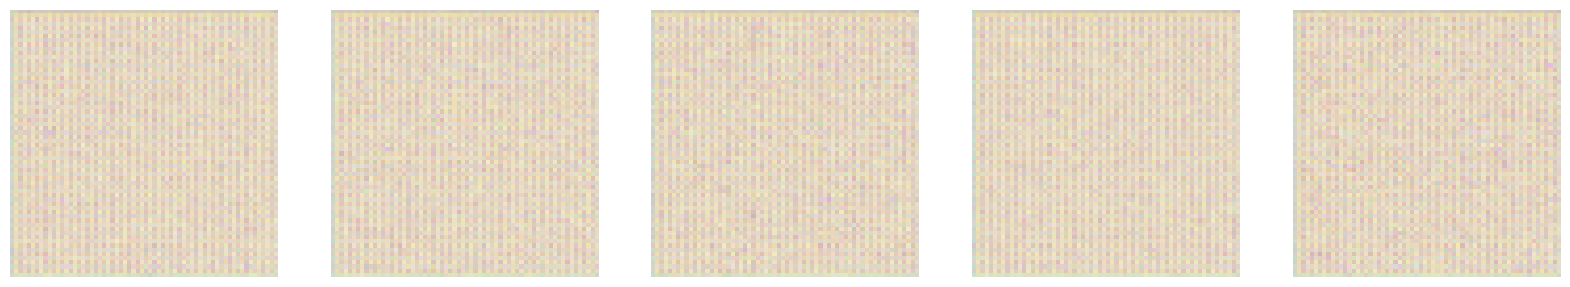

In [5]:


# Build and compile models
generator = build_generator(latent_dim, (img_height, img_width, 3))
discriminator = build_discriminator((img_height, img_width, 3))
discriminator.compile(loss=custom_loss, optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

noise_input = Input(shape=(latent_dim,))
img = generator(noise_input)
discriminator.trainable = False
validity = discriminator(img)
combined = Model(noise_input, validity)
combined.compile(loss=custom_loss, optimizer=Adam(0.0002, 0.5))

# Train GAN
train_gan(generator, discriminator, combined, epochs, batch_size, latent_dim, dataset)




# Generate new images
num_images = 5
generated_imgs = generate_images(generator, latent_dim, num_images)

# Save models
generator.save("generator_model.h5")
discriminator.save("discriminator_model.h5")
print("Models saved as generator_model.h5 and discriminator_model.h5")

# from tensorflow.keras.models import load_model

# # Load the models
# generator = load_model("generator_model.h5", compile=False)
# discriminator = load_model("discriminator_model.h5", custom_objects={"custom_loss": custom_loss})


# Display generated images
fig, axes = plt.subplots(1, num_images, figsize=(20, 20))

for i, img in enumerate(generated_imgs):
    axes[i].imshow((img * 127.5 + 127.5).astype(np.uint8))
    axes[i].axis('off')

plt.show()



In [6]:
# Save generated images
for i, img in enumerate(generated_imgs):
    img_name = f"generated_{i + 1}.png"
    array_to_img(img).save(img_name)
    print(f"Generated image saved as {img_name}")

Generated image saved as generated_1.png
Generated image saved as generated_2.png
Generated image saved as generated_3.png
Generated image saved as generated_4.png
Generated image saved as generated_5.png
